In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kurtosis as scipy_kurtosis 

# Load Data
Load Half-Hourly UK System Cashout Prices.

Data Source: https://www.nordpoolgroup.com/historical-market-data/

In [2]:
file_path = 'https://www.nordpoolgroup.com/48cd48/globalassets/marketdata-excel-files/n2ex-day-ahead-auction-prices_2020_hourly_gbp.xls'
#file_path = '../data/nordpool/n2ex-day-ahead-auction-prices_2018_hourly_gbp.xls'

In [3]:
# Load
raw_list = pd.read_html(file_path, decimal=',')
df = raw_list[0]

### Format Data

In [4]:
# Name Columns
df.columns = ['date','hour_UK','hour_EU','price']

# Format Date Column
df.date = pd.to_datetime(df.date, format='%d-%m-%Y')

# Format Hour Columns
df.hour_UK = df.hour_UK.str.slice(stop = 2)
df.hour_UK = pd.to_numeric(df.hour_UK)
df.hour_EU = df.hour_EU.str.slice(stop = 2)
df.hour_EU = pd.to_numeric(df.hour_EU)

# Convert Price to GBP
df.price = df.price/100

In [5]:
# Check NA values
nan_value_count = df.isna().any(axis=1).sum()
na_df = df.loc[df.isna().any(axis=1)]
#df.price.isna().sum()

print(f"NaN values count: {nan_value_count}")
print(f"NaN values table:")
display(na_df)

NaN values count: 1
NaN values table:


,date,hour_UK,hour_EU,price
2114,2020-03-29,1,2,NaN


In [6]:
# Drop NA values
df = df.dropna()

# Analyse

In [7]:
df.head()

,date,hour_UK,hour_EU,price
0,2020-01-01,23,0,39.94
1,2020-01-01,0,1,43.45
2,2020-01-01,1,2,41.12
3,2020-01-01,2,3,29.98
4,2020-01-01,3,4,27.10


### Exceedance Probability Plot
Log(x) vs. Log(Pr(X>x))

In [8]:
from math import log10

First let's sort the prices from low to high.

Then calculate steps towards an exceedance probability.

In [9]:
sorted_df = df.sort_values(by='price')
sorted_df = sorted_df.reset_index()
sorted_df = sorted_df.rename(columns={'index':'old_index'})

In [10]:
sorted_df['ones'] = 1
sorted_df['cumcount'] = sorted_df.ones.cumsum()
sorted_df['exceedance_count'] = len(sorted_df)-sorted_df.cumcount+1

In [11]:
# Exceedance probability
sorted_df['exceed_prob'] = sorted_df.exceedance_count/len(sorted_df)

In [12]:
#sorted_df['log_price']=sorted_df.price.apply(log10)

In [13]:
sorted_df['log_exceed_prob']=sorted_df.exceed_prob.apply(log10)

In [17]:
sorted_df.head() # Lowest Prices

,old_index,date,hour_UK,hour_EU,price,ones,cumcount,exceedance_count,exceed_prob,log_exceed_prob
0,3448,2020-05-23,15,16,-28.80,1,1,7440,1.000000,0.000000
1,3438,2020-05-23,5,6,-26.60,1,2,7439,0.999866,-0.000058
2,3437,2020-05-23,4,5,-24.93,1,3,7438,0.999731,-0.000117
3,3447,2020-05-23,14,15,-24.00,1,4,7437,0.999597,-0.000175
4,3446,2020-05-23,13,14,-18.80,1,5,7436,0.999462,-0.000234


In [19]:
sorted_df.tail() # Highest Prices

,old_index,date,hour_UK,hour_EU,price,ones,cumcount,exceedance_count,exceed_prob,log_exceed_prob
7435,7436,2020-11-05,18,19,160.00,1,7436,5,0.000672,-3.172603
7436,6211,2020-09-15,18,19,180.62,1,7437,4,0.000538,-3.269513
7437,6955,2020-10-16,18,19,193.20,1,7438,3,0.000403,-3.394452
7438,6355,2020-09-21,18,19,197.10,1,7439,2,0.000269,-3.570543
7439,7435,2020-11-05,17,18,202.25,1,7440,1,0.000134,-3.871573


I'm not sure how it handles tiny values and log(0)

In [22]:
#Maybe Remove tiny values because they blow up when taking log
#sorted_df.price+=-1*sorted_df.price.min()

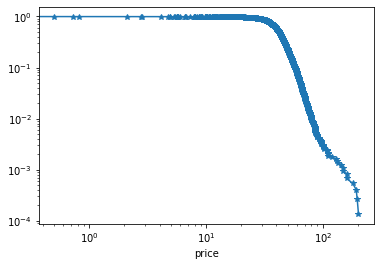

In [23]:
sorted_df.set_index('price').exceed_prob.plot(loglog=True, marker='*')
#sorted_df.plot.scatter('log_price', 'log_exceed_prob')

Alternative code, but this runs more slowly:
```
fig, ax = plt.subplots(constrained_layout=True)
x = np.array([sorted_df.price])
y = np.array([sorted_df.exceed_prob])

ax.loglog(x, y, '*')
ax.set_xlabel('x')
ax.set_ylabel('Probability(price>x)')
ax.set_title('Title')
plt.show()
```

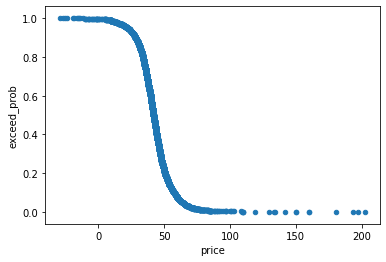

In [24]:
sorted_df.plot.scatter('price', 'exceed_prob')

Conclusions:
* Looks like a power law between ~40 and 70 GBP
* Tail behaves funny it gets fatter then thinner in this particular dataset.

# Appendix:

### Generic Loglog Plot

First show one that's not loglog:

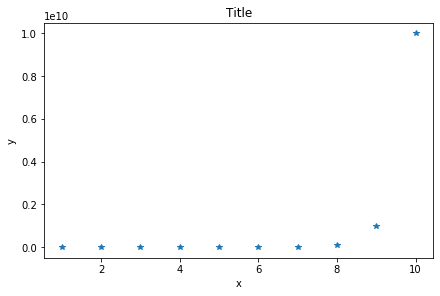

In [25]:
fig, ax = plt.subplots(constrained_layout=True)
x = np.array([1,2,3,4,5, 6,7,8,9,10])
y = np.array([1,10,100,1_000,100_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000])
ax.plot(x, y, '*')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Title')
plt.show()

Now this one IS loglog:

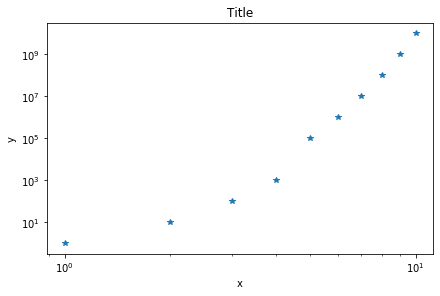

In [26]:
fig, ax = plt.subplots(constrained_layout=True)
x = np.array([1,2,3,4,5, 6,7,8,9,10])
y = np.array([1,10,100,1_000,100_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000])
ax.loglog(x, y, '*')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Title')
plt.show()